# Answer 1
(a)The code is below.

In [5]:
library(mvtnorm)
Y_obs0 <- Y_obs<- read.csv("CitySurvey.csv")
Y_obs[,1]<-log(Y_obs0[,1])
rinwish <- function(n, nu0, iS0) {
    sL0 <- chol(iS0)
    S <- array(dim = c(dim(iS0), n))
    for (i in 1:n)
    {
        Z <- matrix(rnorm(nu0 * dim(iS0)[1]), nu0, dim(iS0)[1]) %*% sL0
        S[, , i] <- solve(t(Z) %*% Z)
    }
    return(S[, , 1:n])
}
Y_obs.mean <- mu_0 <- apply(Y_obs,2, mean)
n<-nrow(Y_obs)
S0 <- Rambda0 <- Sigma <- matrix(cov(Y_obs),nrow = 2)
nu0<-dim(Y_obs)[2]+2
nu0


[1] 4

In [306]:
THETA<-NULL
S<-10000
SIGMA<- array(dim = c(dim(S0),S/2 ))
Y_syn<-NULL
set.seed(101)

for (s in 1:S){
  Rambda_n<-solve(solve(Rambda0)+n*solve(Sigma))
  mu_n<-Rambda_n%*%(solve(Rambda0)%*%mu_0+n*solve(Sigma)%*%Y_obs.mean)
  theta<-rmvnorm(1,mu_n,Rambda_n)
  
  Sn<-S0+(t(Y_obs)-c(theta))%*%t(t(Y_obs)-c(theta))
  Sigma<-rinwish(1,nu0+n,solve(Sn))
  if(s >S/2){
    y<-rmvnorm(1,theta,Sigma)
    y[1]<-exp(y[1])
    Y_syn<-rbind(Y_syn,y)
    THETA<-rbind(THETA,theta)
    SIGMA[,,s-(S/2)]<-Sigma
  }
}

(b)From the below statistics we can see the assumed synthetic data generation have relatively close values in mean ,standard deviation,5th,25th,50th(median),75th and 95th percentile.The difference between the 2 groups on the minimum and the maximum are shown relatively large in this case.Besides, the minimum value of age is negative which is not possible.

In [307]:
sqrt(cov(Y_obs0)[1,1])
sqrt(cov(Y_syn)[1,1])
sqrt(cov(Y_obs0)[2,2])
sqrt(cov(Y_syn)[2,2])


[1] 37870.55

[1] 35811.02

[1] 13.26283

[1] 13.16388

In [308]:
quantile(Y_obs0[,1],c(0,0.05,0.25,0.5,0.75,0.95,1))
quantile(Y_syn[,1],c(0,0.05,0.25,0.5,0.75,0.95,1))


0%     5%    25%    50%    75%    95%   100% 
 24600  32640  46000  60000  90000 150000 214500

0%        5%       25%       50%       75%       95%      100% 
 10615.80  30526.96  47237.55  63951.80  87781.74 139558.69 364586.39

In [309]:
quantile(Y_obs0[,2],c(0,0.05,0.25,0.5,0.75,0.95,1))
quantile(Y_syn[,2],c(0,0.05,0.25,0.5,0.75,0.95,1))

0%   5%  25%  50%  75%  95% 100% 
18.0 24.0 33.0 46.0 54.0 64.8 84.0

0%        5%       25%       50%       75%       95%      100% 
-7.552552 22.508989 35.755481 44.349860 53.075900 65.864523 95.867407

(c)The plot are shown below. We see that the distrubtion of the $Y_sys$ share smiliar figure especialy on income and age espeically the middle part whcih may be a 90% interval .However , when it comes to extreme value, it may cause people to derive poor conculsion because the large difference.

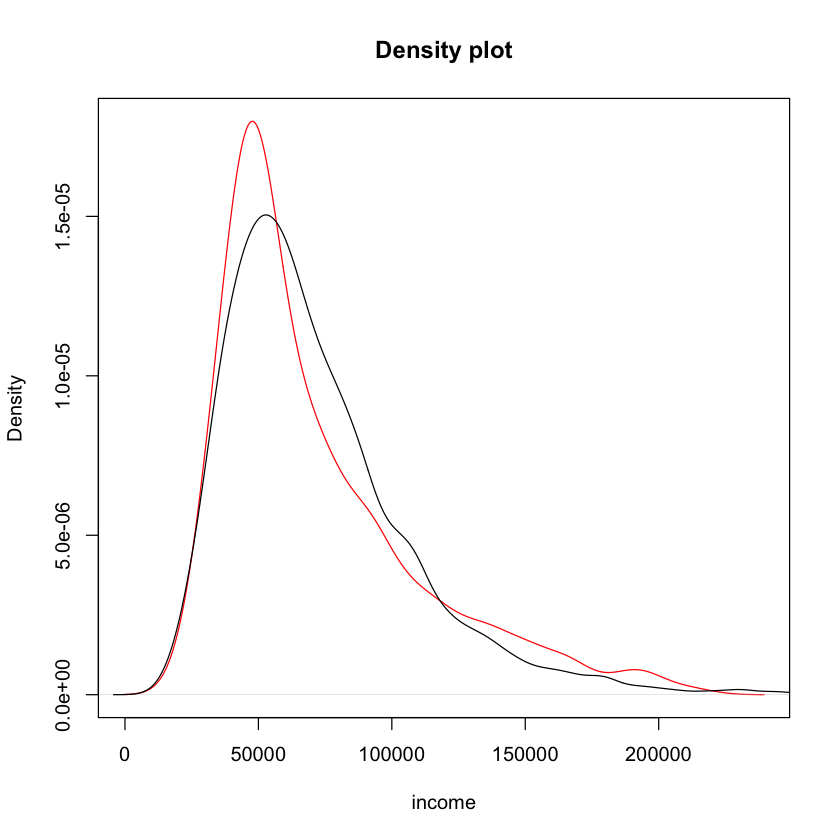

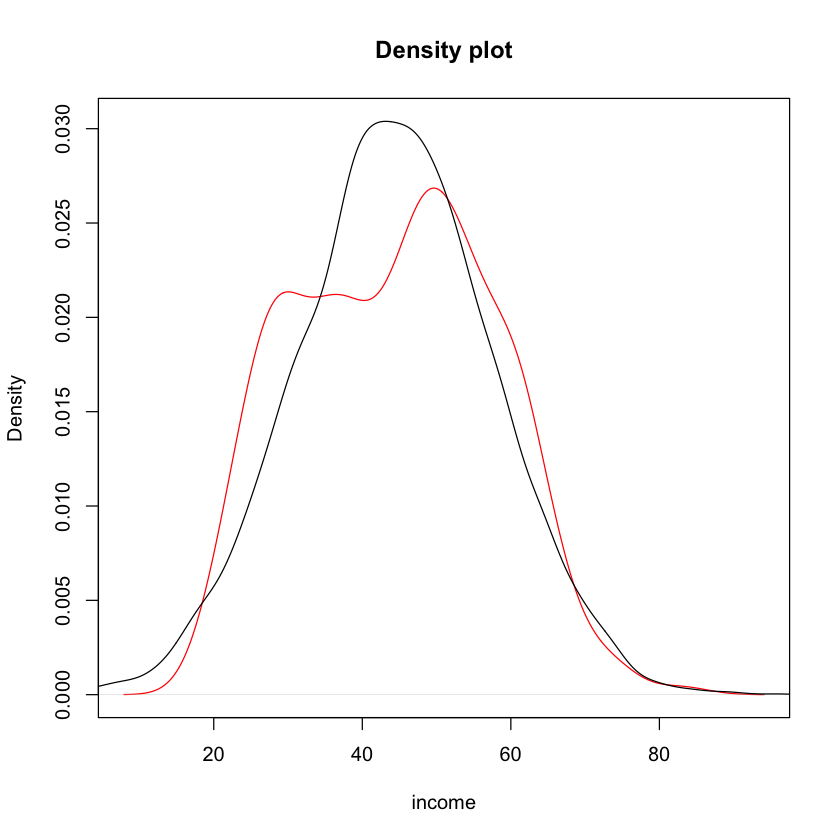

In [310]:
par(bg='white')
plot(density(Y_obs0[,1]),xlab='income',col='red',main='Density plot')
lines(density(Y_syn[,1]))
plot(density(Y_obs0[,2]),xlab='income',ylim=c(0,max(density(Y_syn[,2])[[2]])),col='red',main='Density plot')
lines(density(Y_syn[,2]))


# Answer 2
(a)
The logistic model can be presented as below$$Pr(Y_i=1|\theta_i)=\frac{exp(\theta_i)}{1+exp(\theta_i)}$$
where $\theta$ is the linear model shown as $$\theta_i=X_i\bar{\beta}+\beta_0$$. $X_i$ is a vector of covariates and $\bar{\beta}$ is a vector of coefficiens except intercept which is $\beta_0$.

When we make a model selection the linear part turns into $$\theta_i=X_i(\bar{\gamma\beta})+\beta_0$$ where $\gamma$ is a diagonal matrix with 2 elements $\{1,0\}$ or we can view whole $\bar{\gamma\beta}$ as a vector with $i$ th elements as $\gamma_i\beta_i$ where indicator $\gamma_i=1$ or $0$ means whether to eliminate coefficient $\beta_i(i\neq 0)$.

(b) First , I make the covarites to minus mean and divided by variance so that different covariates have the same scale.Since they have the same scale .Then, we can assume that the $\beta_i(i\neq 0)$ coefficients have independent identical piror distribution $Norm(0,2^2)$ .Since $\beta_0$ is intercept , I assume it follows $Norm(0,4^2)$.And $\gamma_i\sim Bern(1/2)$ .

(c)
The main steps of Metropolis-Hastings algorithm in this case is in every iteration first generating new $\gamma_i$ one by one with Gibbs sampler since $\gamma_i$ is the Bern distribution.Then we generate the $\beta=(\beta_0,\bar{\beta}^T)^T$ with Metropolis-Hastings algorithm.To make a easier sampling (can also generate the whole $\beta$ )here I use $J(\beta^*|\beta^{(s)})\sim MVN(\beta^{(s)},\nu\Sigma)$ which is a symmetric distribution meaning do no contribution to acceptance rates $r$.

(d)I use $\nu=0.5$ as my tuning parameter value ,after about 3000 interations most $\beta_i$ comes to a relatively stationary status and acceptance rates is $32%$ after we burn in the first 3000 iterations.When $\nu=2$ ,steps may be too big ,the acceptacne is only about $14%$.


In [7]:
p2<-read.csv('Recidivism.csv')
set.seed(101)
p2$X...Gender<- ifelse(p2$X...Gender=='M' ,1,0)
p2$Race<- ifelse(p2$Race=='WHITE' ,1,0)
p2$Recidivism_Arrest_Year1<- ifelse(p2$Recidivism_Arrest_Year1=='TRUE',1,0)
# VAR<-var(p2)
for(i in 1:(ncol(p2)-1)){
    p2[,i]<-(p2[,i]-mean(p2[,i]))/var(p2[,i])
}
x<-as.matrix(p2[,1:10])
y<-as.matrix(p2[,11])
# p2$X...Gender <-factor(p2$X...Gender)
# p2$Race <-factor(p2$Race)
# p2$Recidivism_Arrest_Year1 <-factor(p2$Recidivism_Arrest_Year1)
attach(p2)
model.fit<-glm(y ~ 1+x ,family = binomial(link=logit))
#glm(Recidivism_Arrest_Year1 ~ X...Gender+Race+Age_at_Release+Supervision_Level+Educ_HighSchool+Educ_College+Dependents+Prison_Years_plus2+Prior_Conviction_Felony+Prior_Conviction_Misd,family = binomial(link=logit))
summary.coe<-summary(model.fit)$coefficients
detach(p2)



In [8]:
summary.coe
p<-nrow(summary.coe)
p

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-0.91133221,0.014337840,-63.561332,0.000000e+00
xX...Gender,0.04881845,0.005144721,9.489039,2.331743e-21
xRace,-0.02204699,0.007126481,-3.093671,1.976965e-03
xAge_at_Release,-3.86139141,0.190553337,-20.264098,2.668070e-91
xSupervision_Level,0.03973130,0.007427567,5.349168,8.835967e-08
xEduc_HighSchool,0.01291468,0.007511832,1.719245,8.556979e-02
xEduc_College,-0.02703406,0.006360042,-4.250610,2.131892e-05
xDependents,-0.01311463,0.006482841,-2.022975,4.307569e-02
xPrison_Years_plus2,-0.08373527,0.007183829,-11.656077,2.136610e-31
xPrior_Conviction_Felony,0.07069621,0.006924299,10.209873,1.790996e-24


[1] 11

In [9]:

ilogit<-function(theta){
  out<-exp(theta)/(1+exp(theta))
  return(out)
}

[1] 0.1444278

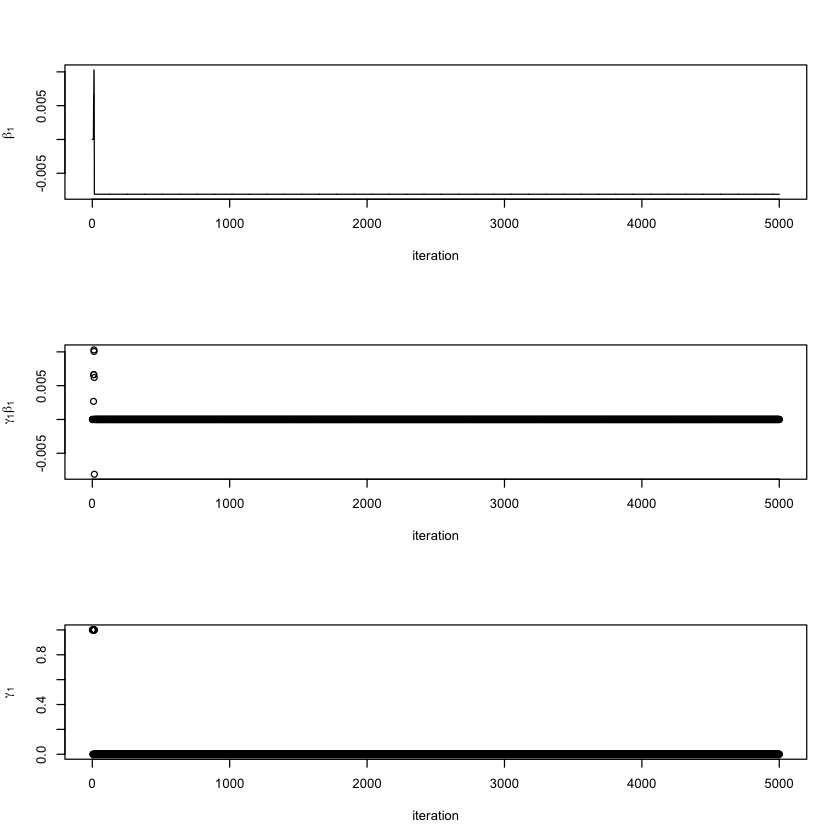

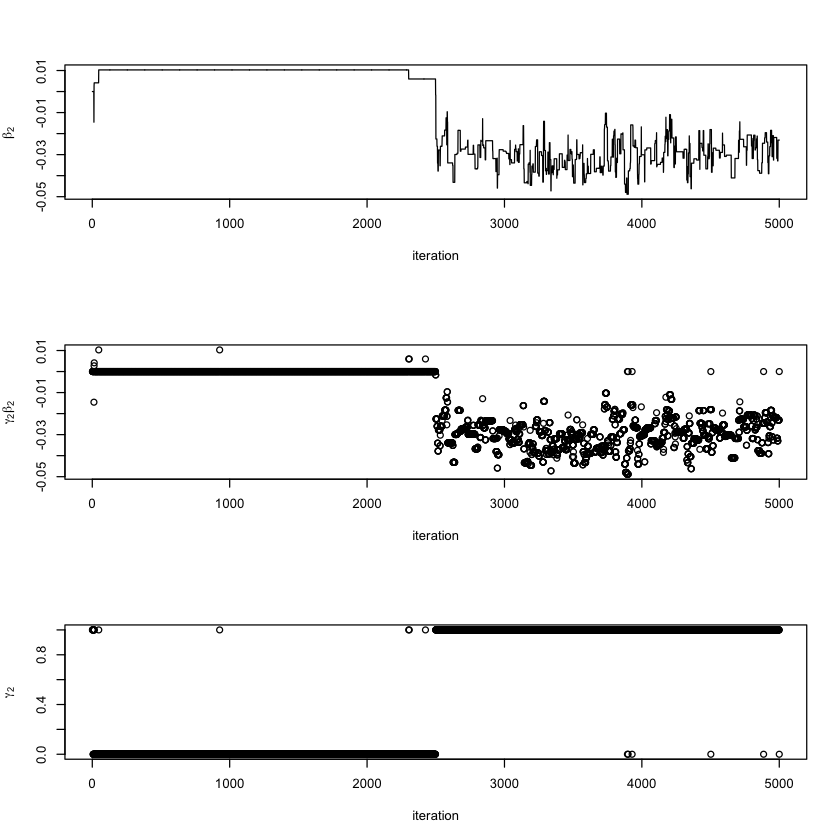

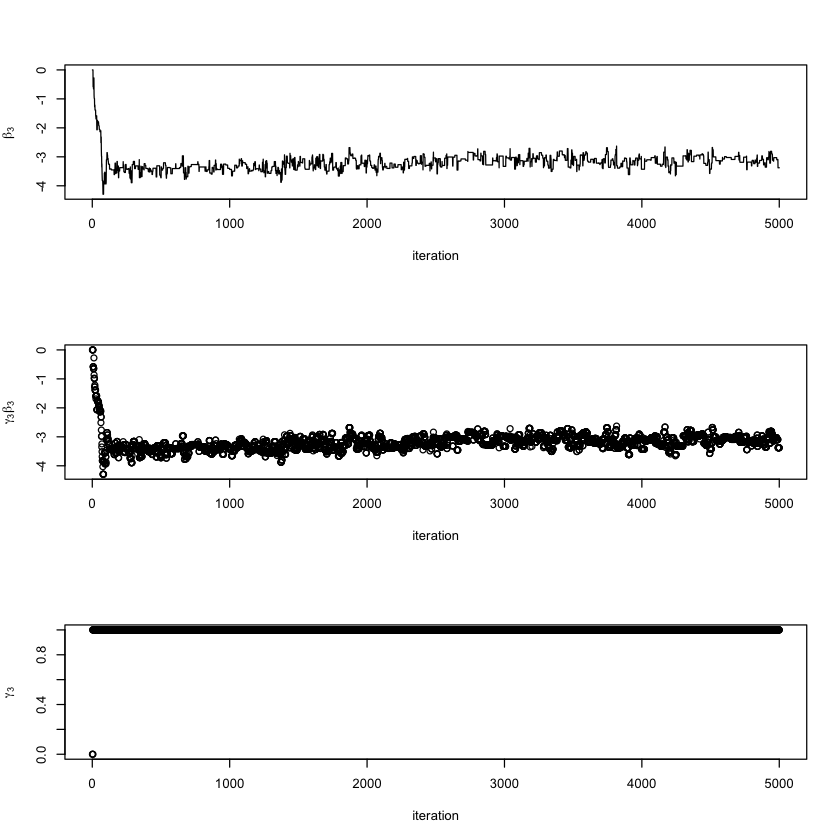

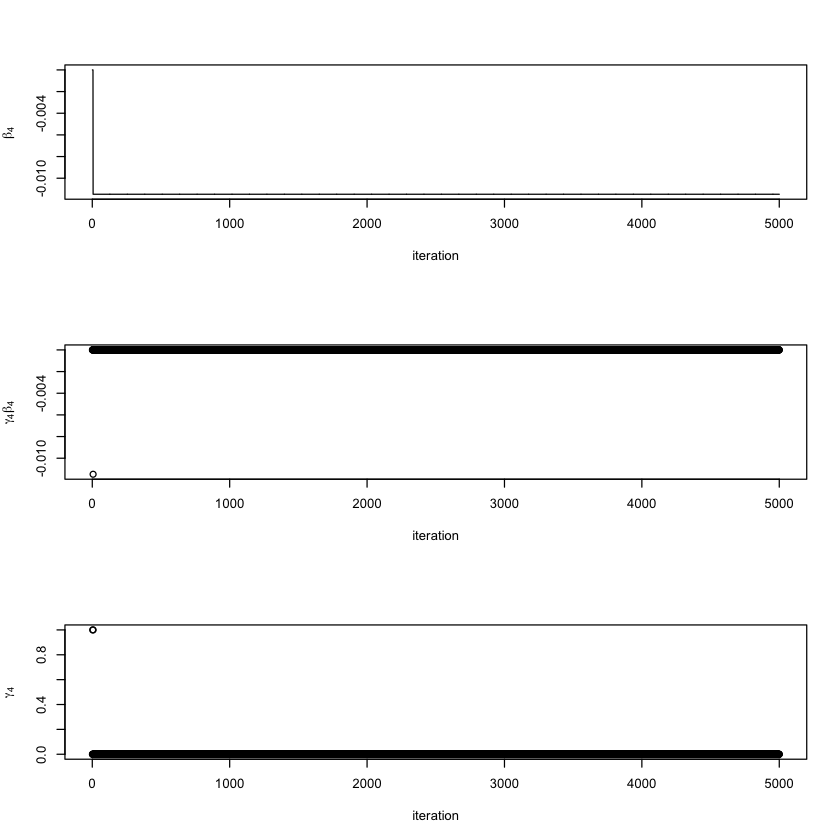

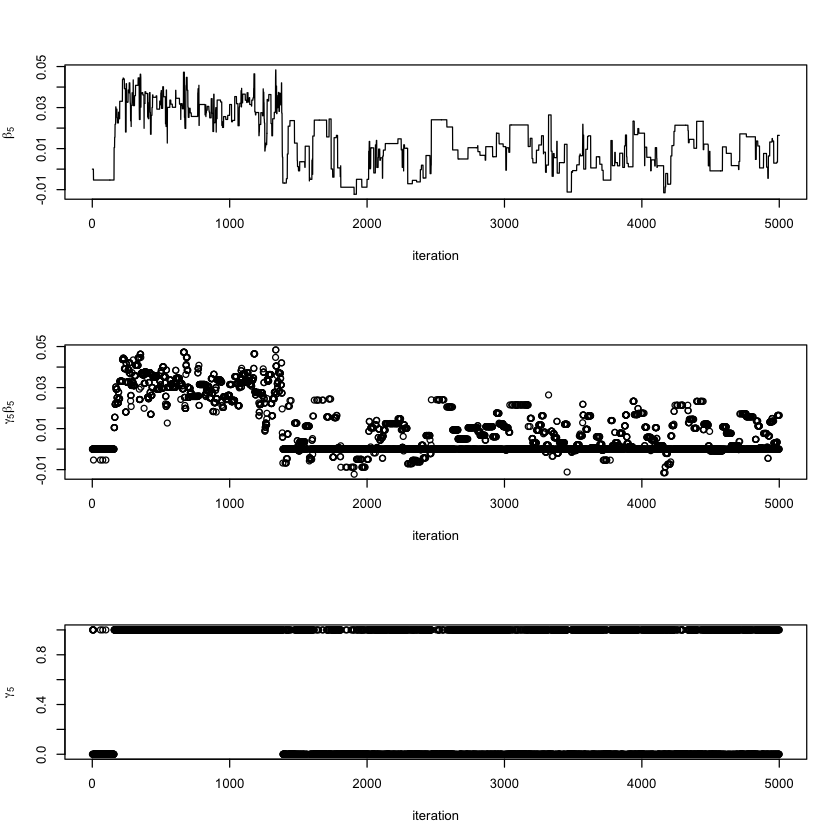

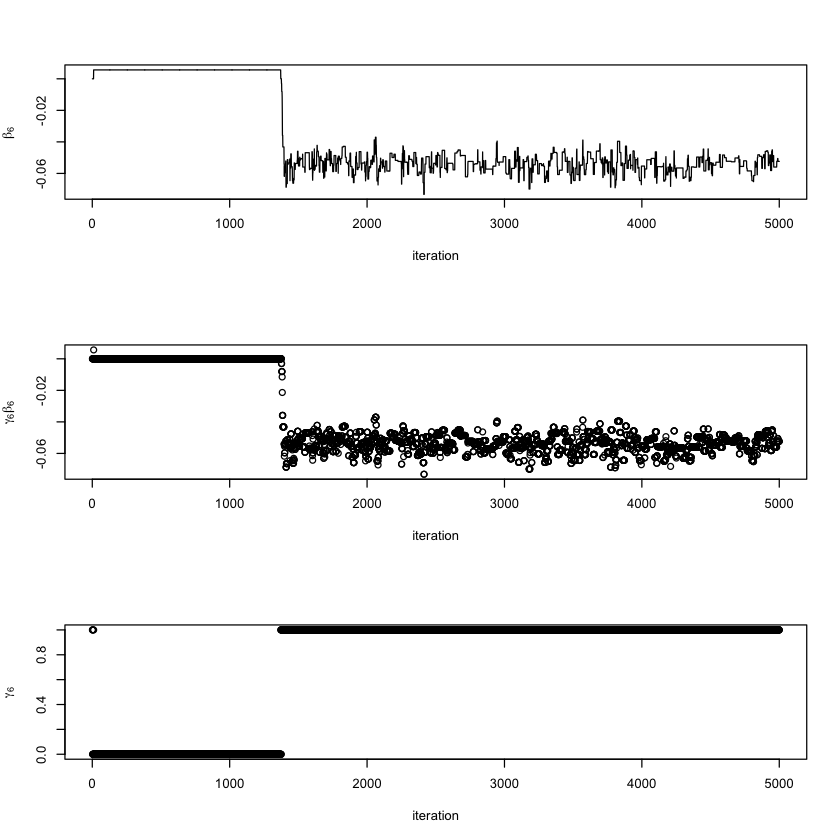

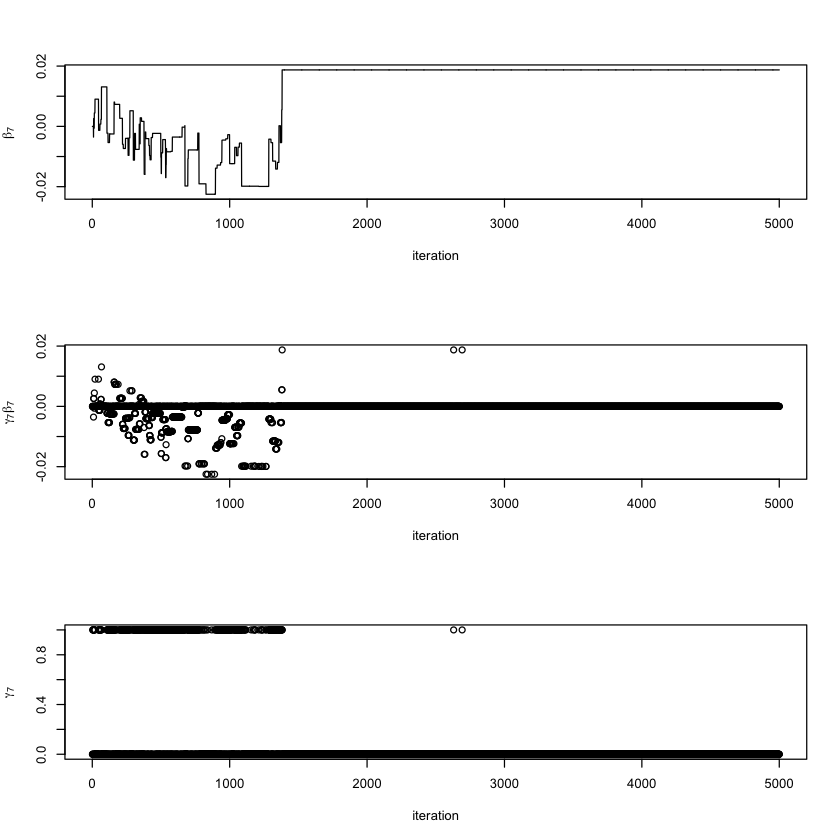

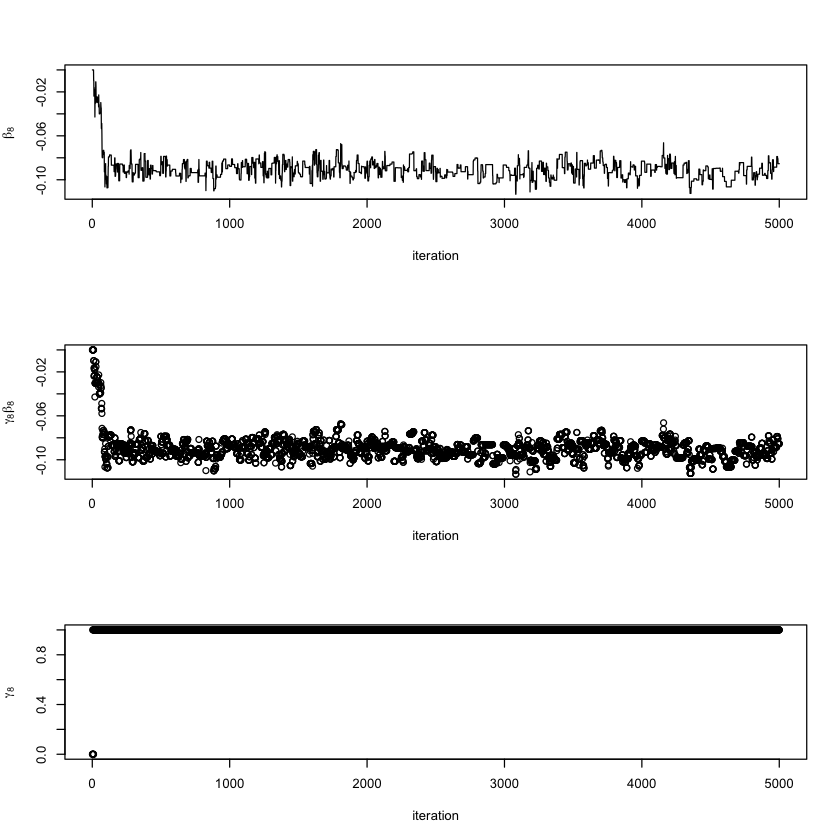

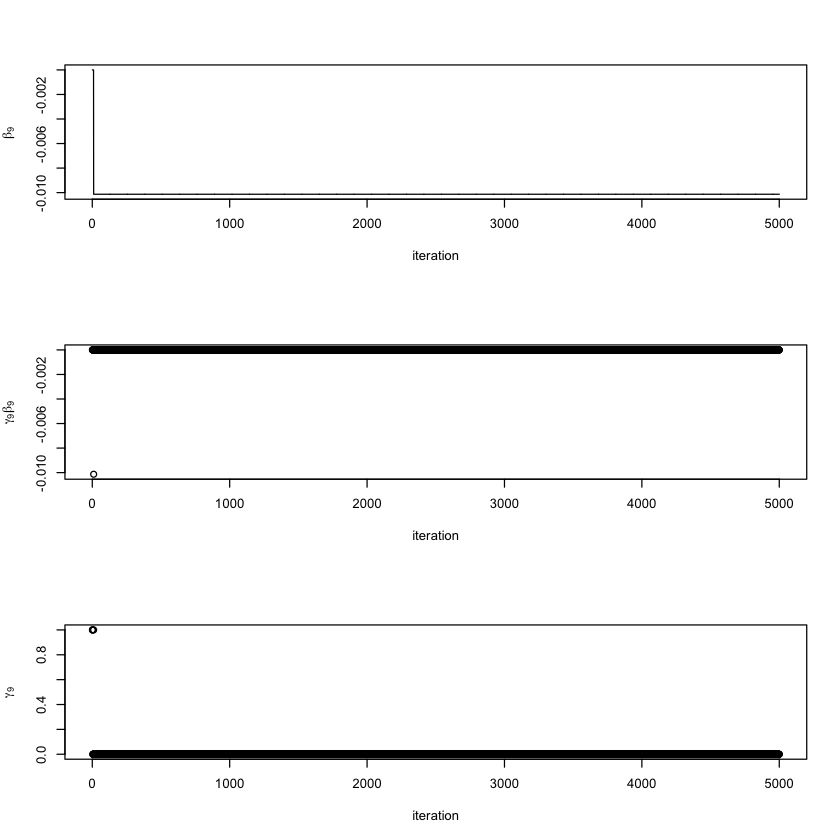

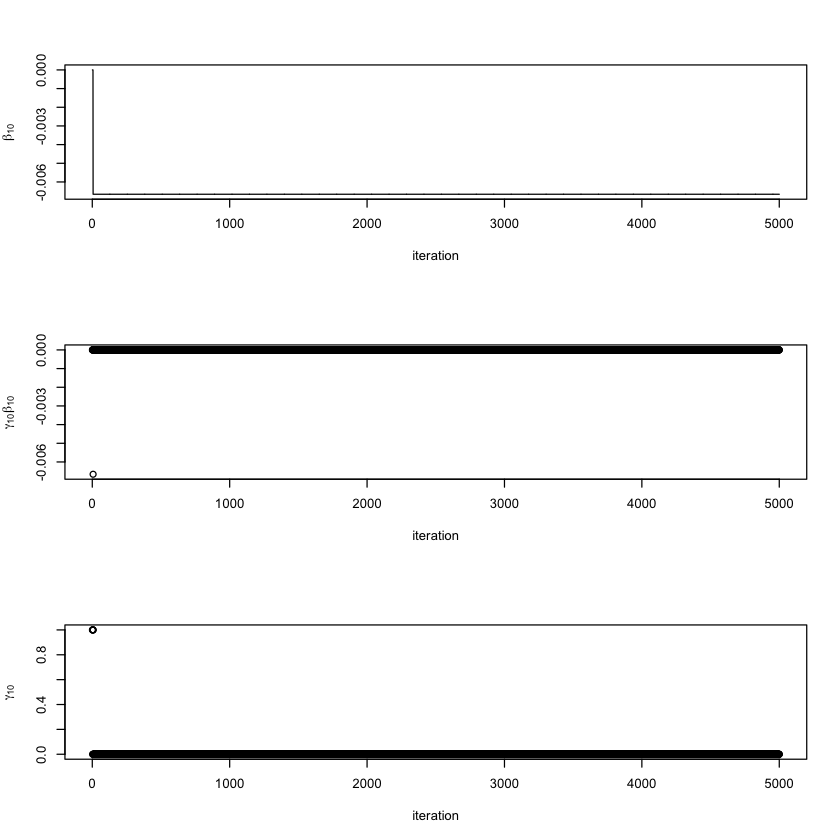

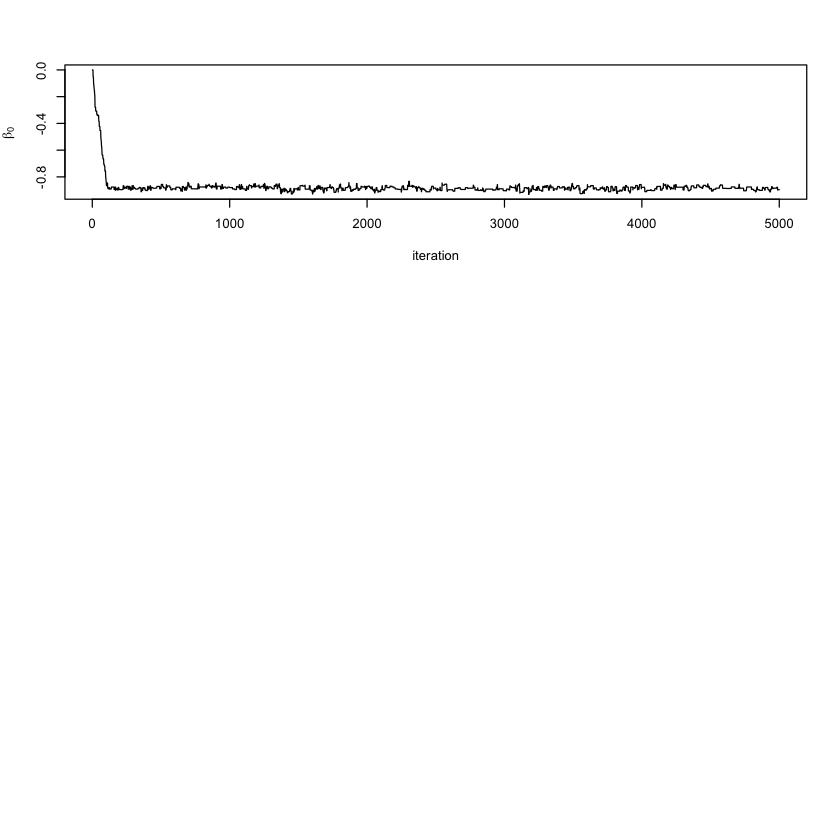

In [10]:
beta.pm<-rep(0,p)
beta.psd<-c(4,rep(2,p-1))
gamma<- rbinom(p-1,1,0.5)
beta<- rep(0,p)#summary.coe[,1]
beta.var<-summary(model.fit)$cov.unscaled
S2<- 1000*5
Beta<-P<-NULL
Gamma<-NULL
nu<-2
acc<- NULL
for(i in 1:S2){
    for(j in 1:(p-1)) {
        new_gamma<- gamma
        new_gamma[j]<- 1-gamma[j]
        p0<-ilogit(x%*%(matrix(beta[-1]*gamma))+beta[1])
        p1<-ilogit(x%*%(matrix(beta[-1]*new_gamma))+beta[1])
        logp <- sum((dbinom(y,1,p1,log=T)-dbinom(y,1,p0,log=T)))
        pj<-rbinom(1,1,1/(1+exp(-logp)))
        gamma[j]<- pj*new_gamma[j]+(1-pj)*gamma[j]
        }
    new_beta<- rmvnorm(1,beta,nu*beta.var)
    p0<-ilogit(x%*%(matrix(beta[-1]*gamma))+beta[1])
    p1<-ilogit(x%*%(matrix(new_beta[-1]*gamma))+new_beta[1])
    # jbeta<-dmvnorm(beta,new_beta,nu*beta.var,log=T)
    # new_jbeta<- dmvnorm(new_beta,beta,nu*beta.var,log=T)
    logp <- sum(dbinom(y,1,p1,log=T)-dbinom(y,1,p0,log=T))+sum((dnorm(new_beta,beta.pm,beta.psd,log=T)-dnorm(beta,beta.pm,beta.psd,log=T))*c(1,gamma))#-new_jbeta+jbeta
    if(log(runif(1))<logp){
        beta<-new_beta*c(1,gamma)+beta*c(0,1-gamma)
        acc <- c(acc,1)
    }
    else{
        acc<-c(acc,0)
    }
    Beta<-rbind(Beta,beta)
    Gamma<-rbind(Gamma,gamma)
}

mean(acc[3000:S2])
par(bg='white',mfrow=c(3,1))
for(i in 1:(p-1)){
    plot(Beta[,i+1],type='l',ylab=bquote(beta[.(i)]),xlab='iteration')
    plot(Gamma[,i]*Beta[,i+1],ylab=bquote(gamma[.(i)]*beta[.(i)]),xlab='iteration')
    plot(Gamma[,i],ylab=bquote(gamma[.(i)]),xlab='iteration')
}
plot(Beta[,0+1],type='l',ylab=bquote(beta[.(0)]),xlab='iteration')

[1] 0.3298351

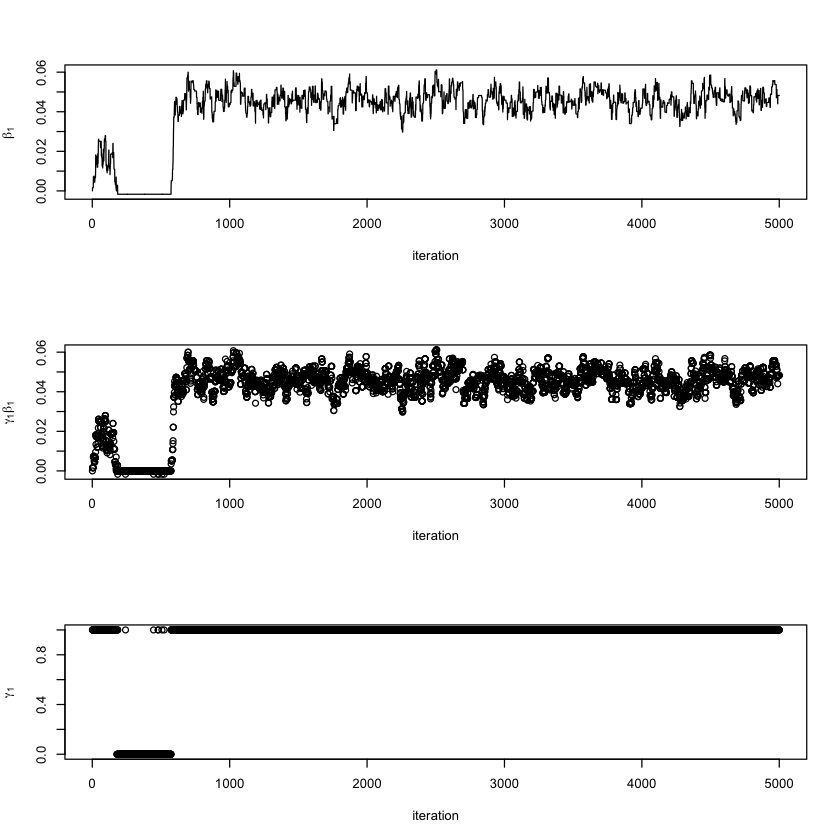

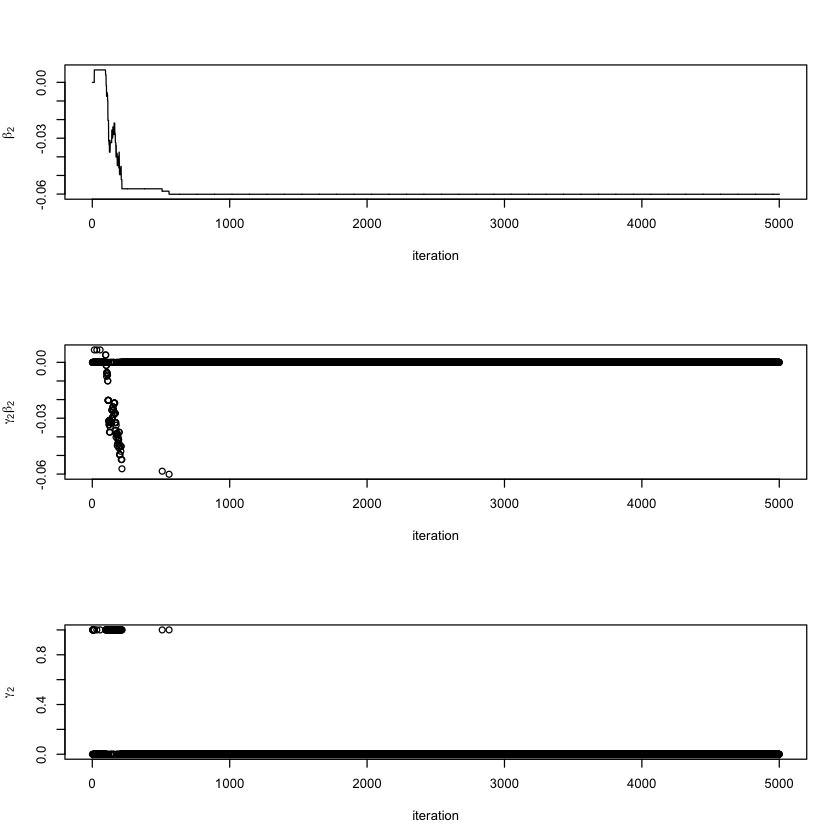

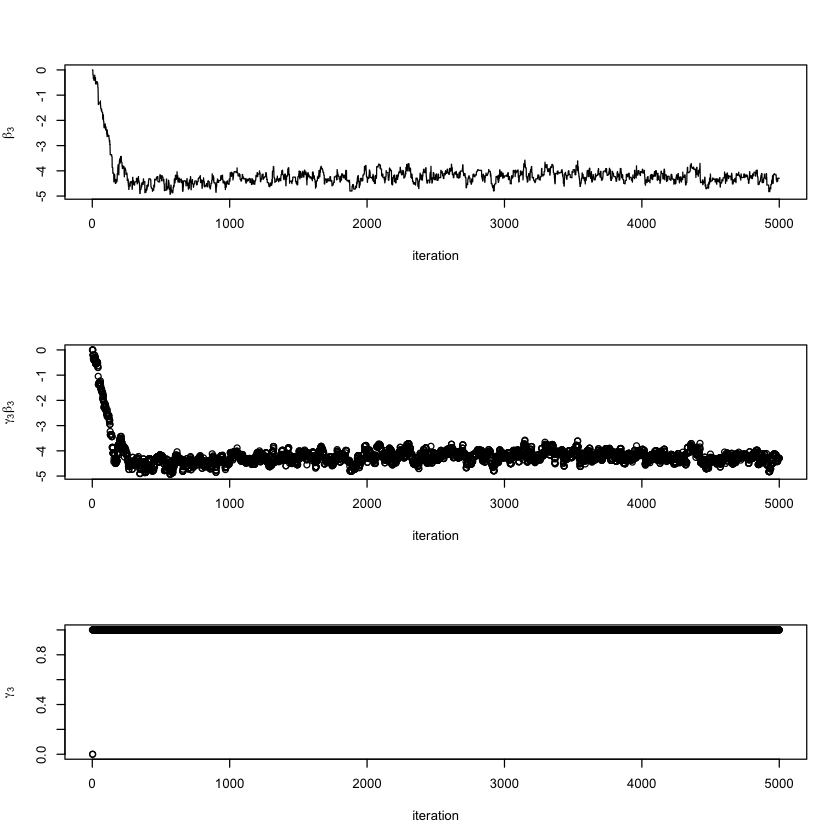

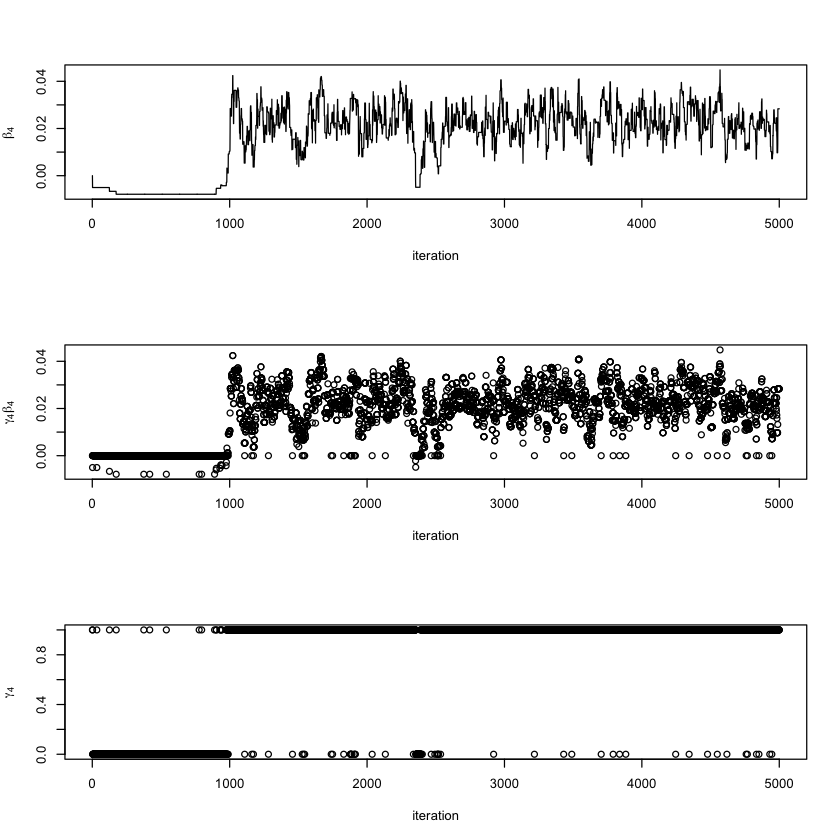

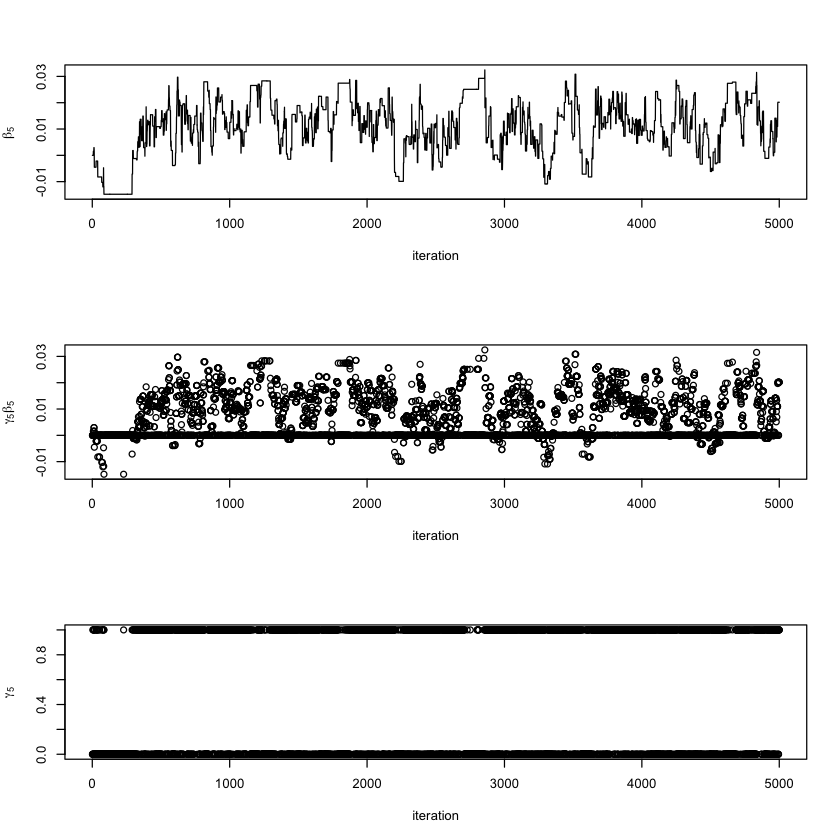

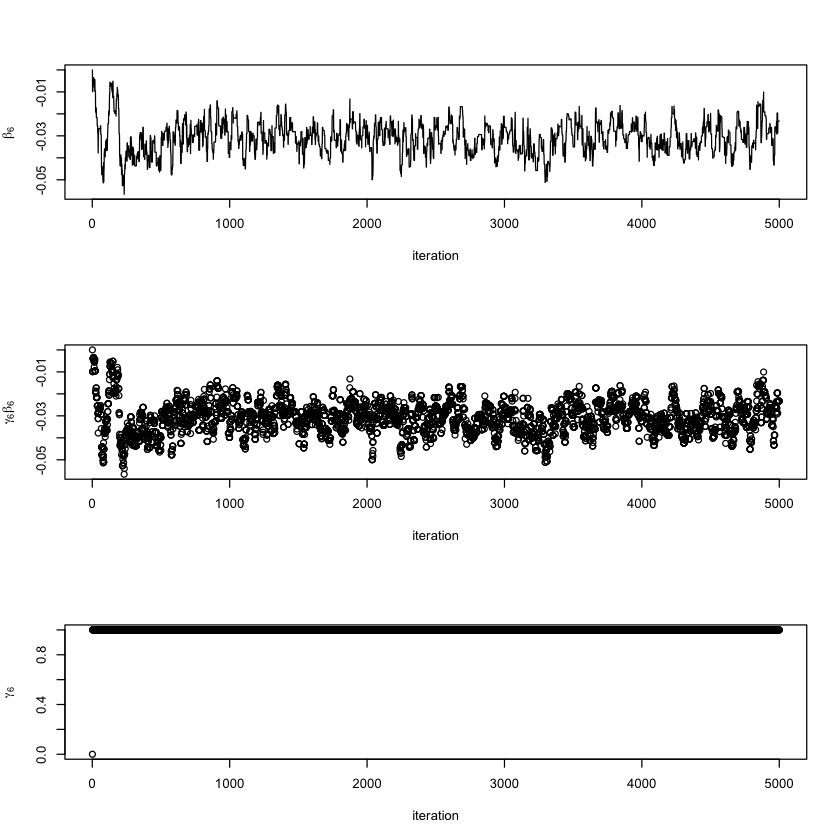

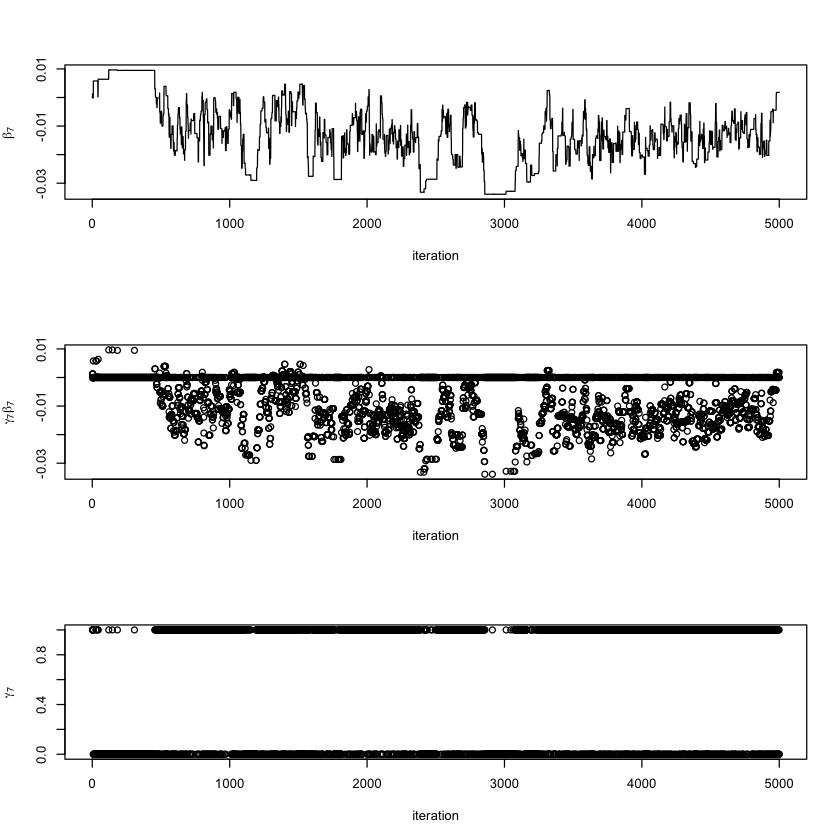

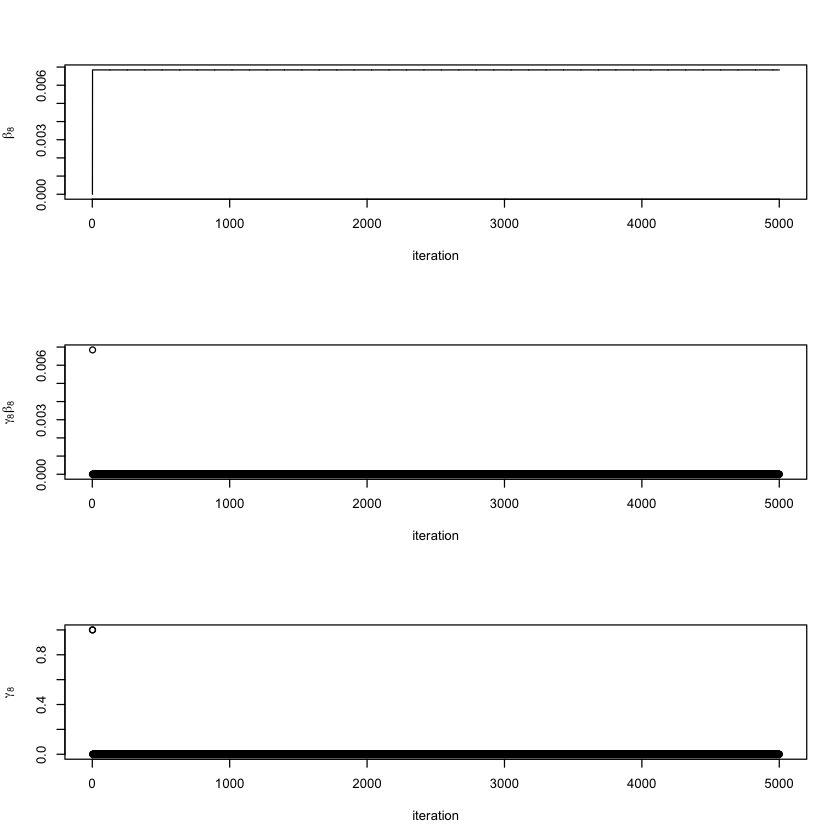

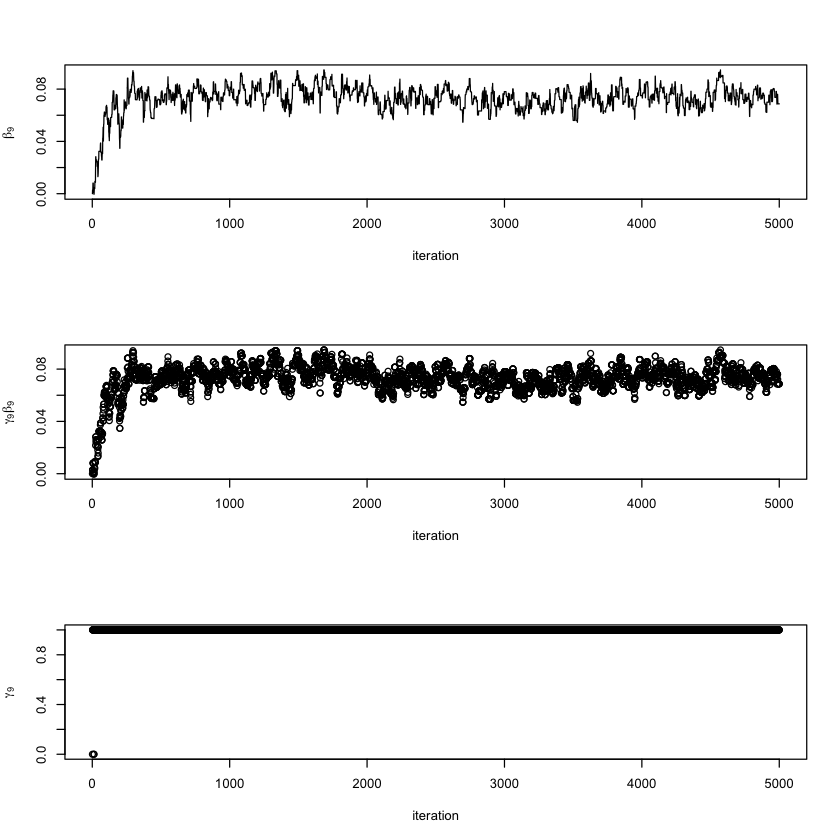

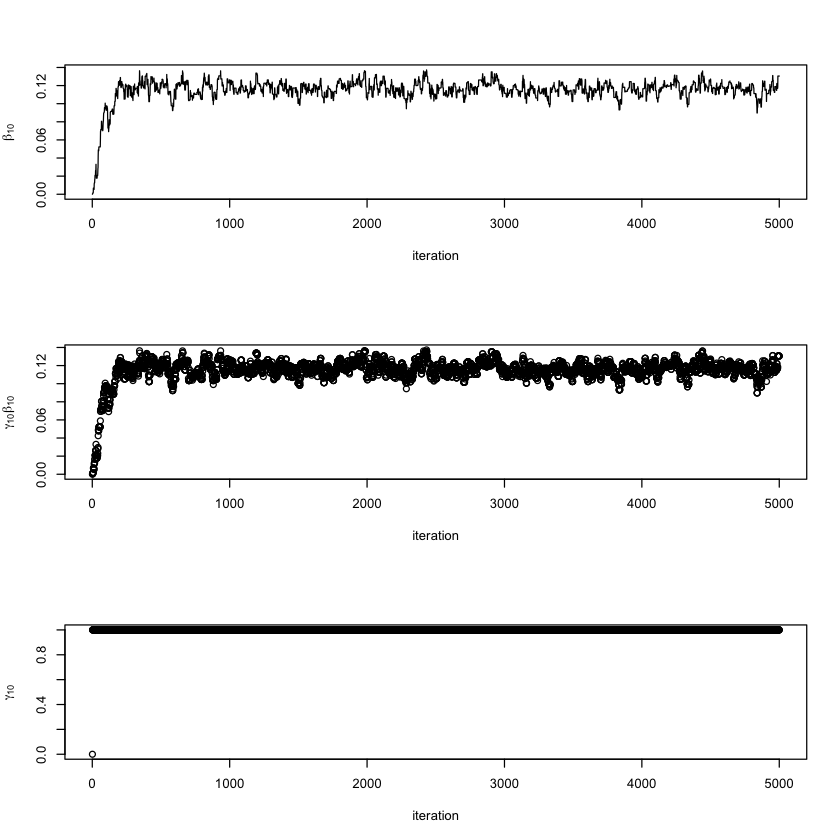

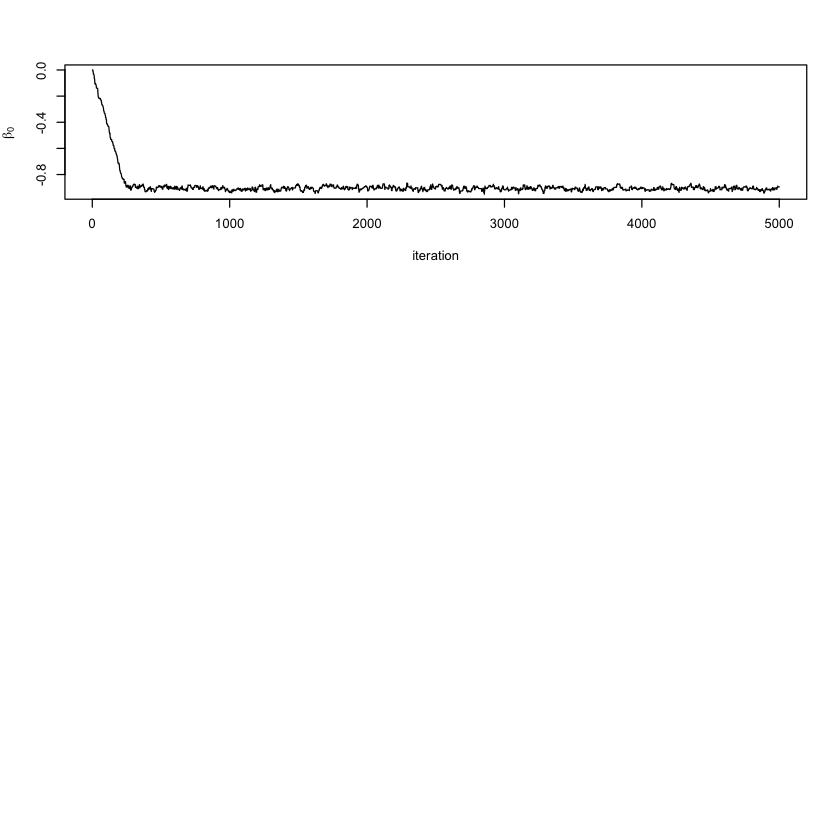

In [316]:
beta.pm<-rep(0,p)
beta.psd<-c(4,rep(2,p-1))
gamma<- rbinom(p-1,1,0.5)
beta<- rep(0,p)#summary.coe[,1]
beta.var<-summary(model.fit)$cov.unscaled
S2<- 1000*5
Beta<-P<-NULL
Gamma<-NULL
nu<-0.5
acc<- NULL
for(i in 1:S2){
    for(j in 1:(p-1)) {
        new_gamma<- gamma
        new_gamma[j]<- 1-gamma[j]
        p0<-ilogit(x%*%(matrix(beta[-1]*gamma))+beta[1])
        p1<-ilogit(x%*%(matrix(beta[-1]*new_gamma))+beta[1])
        logp <- sum((dbinom(y,1,p1,log=T)-dbinom(y,1,p0,log=T)))
        pj<-rbinom(1,1,1/(1+exp(-logp)))
        gamma[j]<- pj*new_gamma[j]+(1-pj)*gamma[j]
        }
    new_beta<- rmvnorm(1,beta,nu*beta.var)
    p0<-ilogit(x%*%(matrix(beta[-1]*gamma))+beta[1])
    p1<-ilogit(x%*%(matrix(new_beta[-1]*gamma))+new_beta[1])
    # jbeta<-dmvnorm(beta,new_beta,nu*beta.var,log=T)
    # new_jbeta<- dmvnorm(new_beta,beta,nu*beta.var,log=T)
    logp <- sum(dbinom(y,1,p1,log=T)-dbinom(y,1,p0,log=T))+sum((dnorm(new_beta,beta.pm,beta.psd,log=T)-dnorm(beta,beta.pm,beta.psd,log=T))*c(1,gamma))#-new_jbeta+jbeta
    if(log(runif(1))<logp){
        beta<-new_beta*c(1,gamma)+beta*c(0,1-gamma)
        acc <- c(acc,1)
    }
    else{
        acc<-c(acc,0)
    }
    Beta<-rbind(Beta,beta)
    Gamma<-rbind(Gamma,gamma)
}

mean(acc[3000:S2])
par(bg='white',mfrow=c(3,1))
for(i in 1:(p-1)){
    plot(Beta[,i+1],type='l',ylab=bquote(beta[.(i)]),xlab='iteration')
    plot(Gamma[,i]*Beta[,i+1],ylab=bquote(gamma[.(i)]*beta[.(i)]),xlab='iteration')
    plot(Gamma[,i],ylab=bquote(gamma[.(i)]),xlab='iteration')
}
plot(Beta[,0+1],type='l',ylab=bquote(beta[.(0)]),xlab='iteration')

(e)
$\beta_{0,1,3,6,9,10}$ are important which means Gender,Age_at_Release,Educ_College,Prior_Conviction_Felony,Prior_Conviction_Misd are important variables.The mean and interval are shown in the below print.We may remove Gender variable because it include zero in its interval.

In [333]:
print('Index       Mean         Interval')
for(i in c(1,3,6,9,10)){
    print(c(i,mean(Beta[,i+1]),quantile(Beta[,i+1],c(0.025,0.975))))
}

[1] "Index       Mean         Interval"
                                  2.5%        97.5% 
 1.000000000  0.040957782 -0.001685456  0.055632396 
                         2.5%     97.5% 
 3.000000 -4.186117 -4.718956 -2.793553 
                               2.5%       97.5% 
 6.00000000 -0.03072141 -0.04424430 -0.01664913 
                            2.5%      97.5% 
9.00000000 0.07289874 0.05401909 0.08936938 
                               2.5%       97.5% 
10.00000000  0.11493954  0.09143464  0.13071354 


(f)
It seems still high auto-correlation which may suggest us select data with a rate such as 1 in 10. When we run the iteration, we only record the data only the numbers of iteration mod 10 equals to zero.

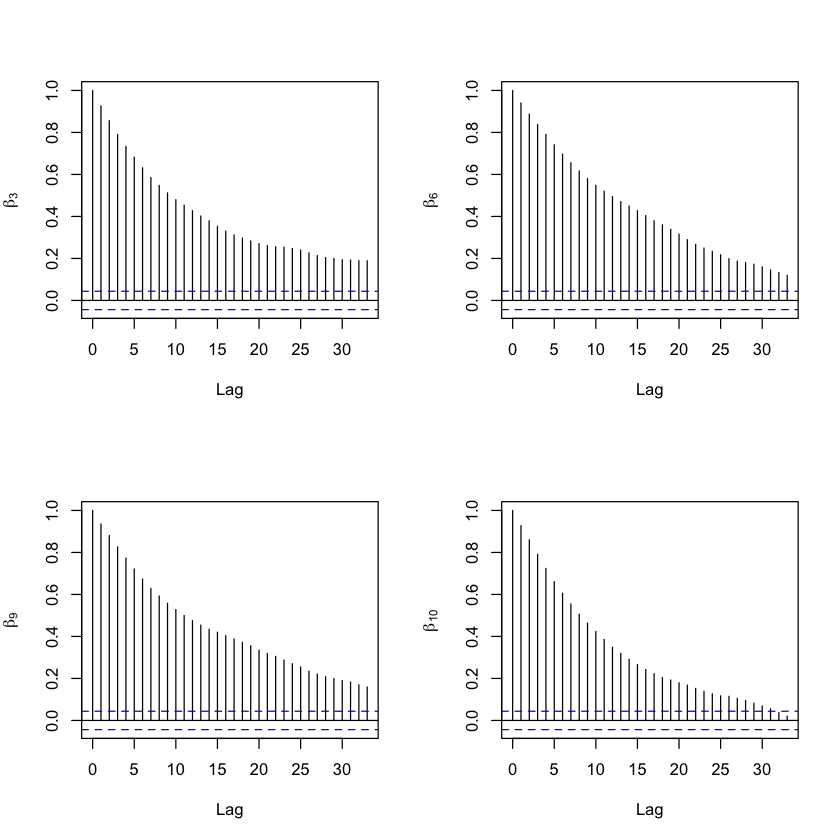

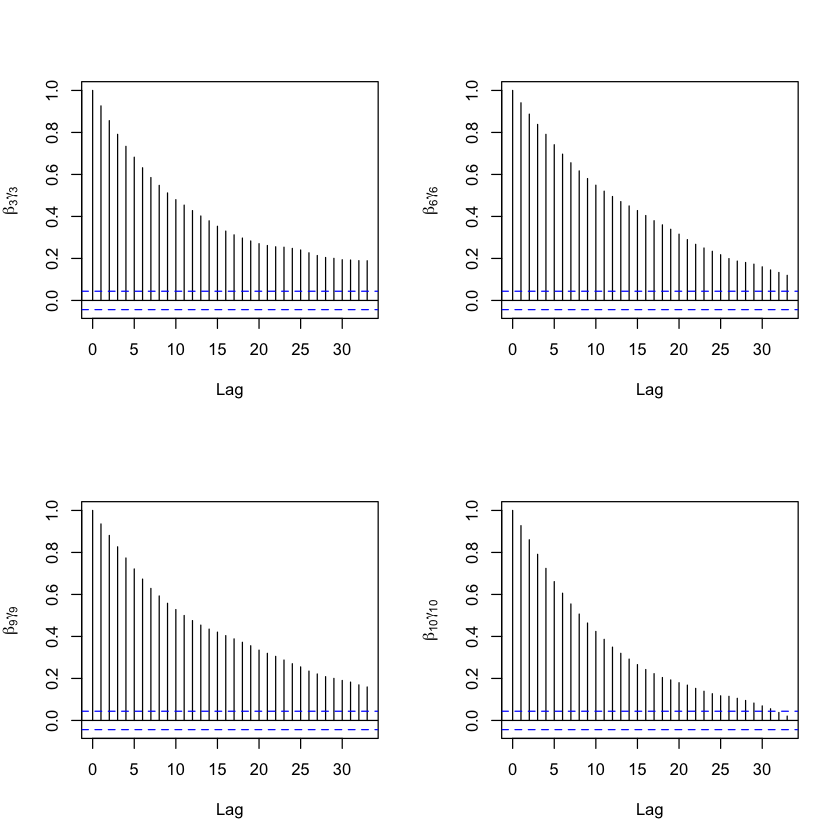

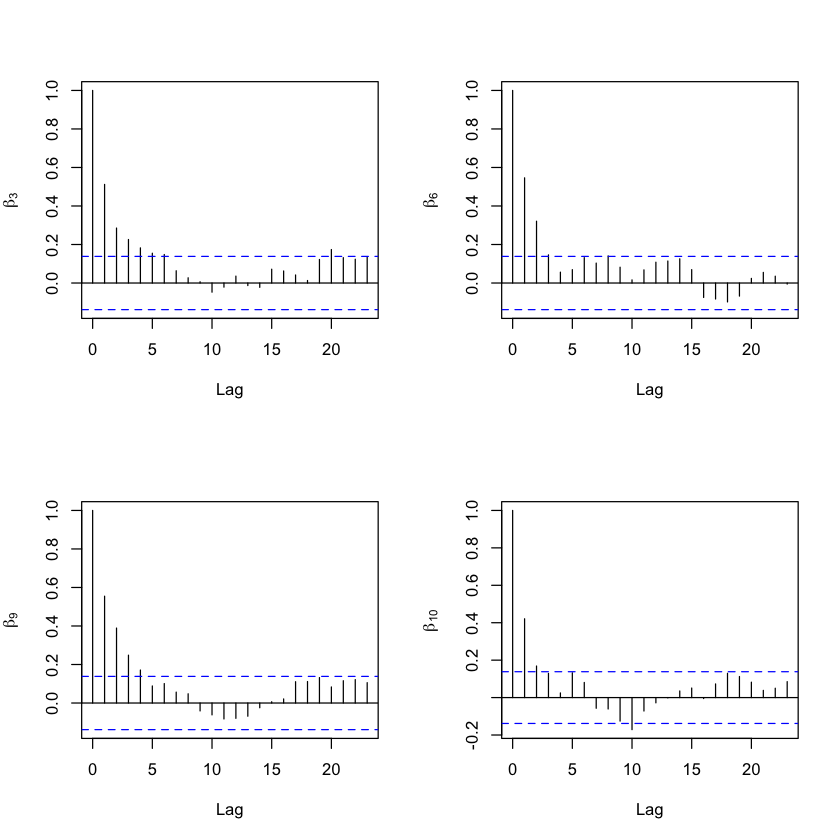

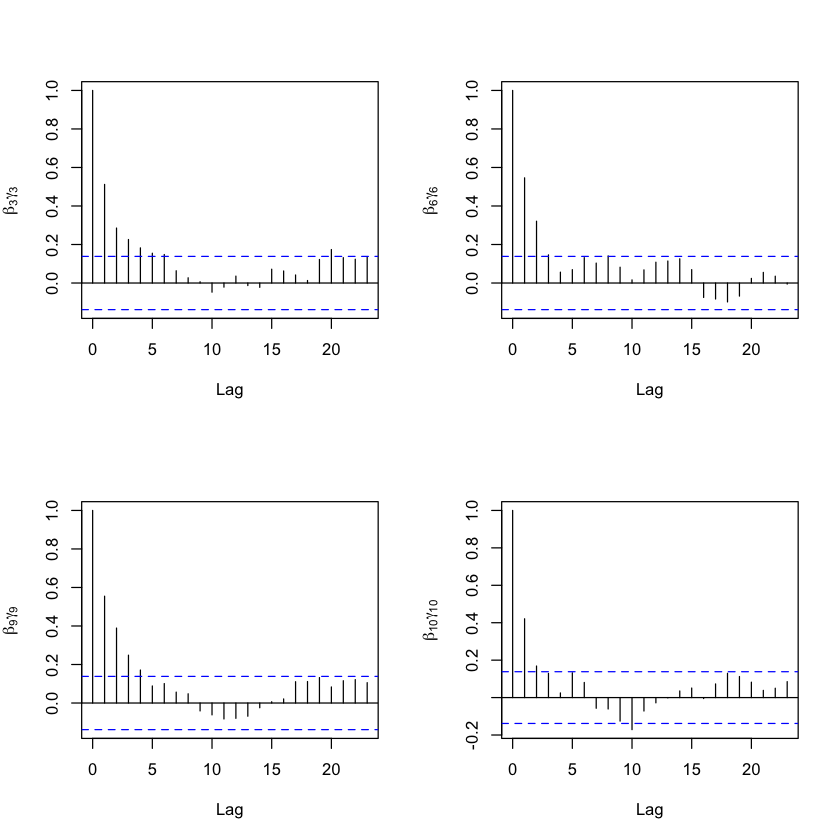

In [353]:
par(bg='white',mfrow=c(2,2))
for(i in c(3,6,9,10)){
    acf(Beta[3000:S2,i+1],main="",ylab=bquote(beta[.(i)]))
}
for(i in c(3,6,9,10)){
    acf(Beta[3000:S2,i+1]*Gamma[3000:S2,i],main="",ylab=bquote(beta[.(i)]*gamma[.(i)]))
}
for(i in c(3,6,9,10)){
    acf(Beta[seq(3000,S2,by=10),i+1],main="",ylab=bquote(beta[.(i)]))
}
for(i in c(3,6,9,10)){
    acf(Beta[seq(3000,S2,by=10),i+1]*Gamma[seq(3000,S2,by=10),i],main="",ylab=bquote(beta[.(i)]*gamma[.(i)]))
}

# Answer 3
There are some missing data so we may ingnore them due to the Hierarchical Normal Modeling but not the MVN modeling.

(a)
$\mu_0=\bar{y}$ while others need to be small to be small except $\gamma_0^2$ which should be big so that the priors are weakly informative.

(b)
The code was shown below
(c)
It seems 30000 is enough because the chain shows stationary.


In [33]:
#q3
q3<-read.csv('formula1.csv')
n3<-nrow(q3)
nc<-ncol(q3)-1
y_sumsq<-0
Y<-NULL
M<-0
Y_bar <- NULL
for (i in 1:n3) {
    y<-(q3[i,-1])[FALSE==is.na((q3[i,-1]))]
    Y<-c(Y,y)
    M<-c(M,M[i]+length(y))
    Y_bar <- c(Y_bar,mean(y))
    theta <- Y_bar
    y_sumsq <- sum((y-theta[i])^2)+y_sumsq
}
# M
# Y[(M[20]+1):M[21]]
# Y_bar
mu<-mu0 <-mean(Y)-100
S3<-1000
lambda0_sq <- 1000000
tao_sq <- tao0_sq <- 1
eta0 <- 1/2
sigma_sq <- sigma0_sq <- 1
nu0 <- 1/2
THETA <- MST<-SIGMA_sq <- NULL
n<-M[21]
theta_sumsq<-sum((theta-mu)^2)
post_norm_arg <- function(n,y_bar,mu0,sigma_sq,tao_sq){
    return(c(((n*y_bar/sigma_sq)+(mu0/tao_sq))/(n/sigma_sq+1/tao_sq),1/(n/sigma_sq+1/tao_sq)))
}
post_gamma_arg <- function(m,sum_sq,nu_0,tao0_sq){
    return(c((nu_0+m)/2,(nu_0*tao0_sq+sum_sq)/2))
}


In [34]:
mean(Y)

[1] 232.9271

In [35]:

for(i in 1:S3){
    arg <- post_norm_arg(8,mean(theta),mu0,tao_sq,lambda0_sq)
    mu <- rnorm(1,arg[1],sqrt(arg[2]))
    arg <- post_gamma_arg(8,theta_sumsq,eta0,tao0_sq)
    tao_sq <- 1/rgamma(1,arg[1],arg[2])
    arg <- post_gamma_arg(n,y_sumsq,nu0,sigma0_sq)
    sigma_sq <- 1/rgamma(1,arg[1],arg[2])
    y_sumsq<-0
    for (j in 1:n3){
        m<- M[j+1]-M[j]
        y_bar<- Y_bar[j]
        y<- Y[(M[j]+1):M[j+1]]
        arg<-post_norm_arg(m,y_bar,mu,sigma_sq,tao_sq)
        theta[j] <- rnorm(1,arg[1],sqrt(arg[2]))
        y_sumsq <- sum((y-theta[j])^2)+y_sumsq
    }
    theta_sumsq<-sum((theta-mu)^2)
    THETA<-rbind(THETA,c(theta))
    MST<-rbind(MST,c(mu,sigma_sq,tao_sq))

}


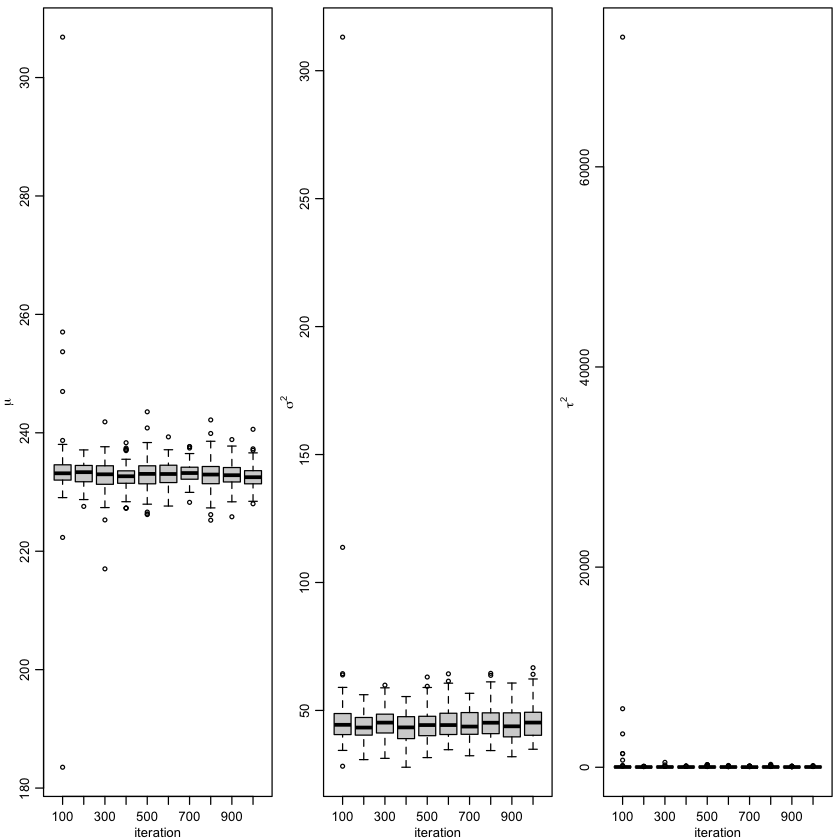

In [36]:
stationarity.plot<-function(x,...){
  
  S<-length(x)
  scan<-1:S
  ng<-min( round(S/100),10)
  group<-S*ceiling( ng*scan/S) /ng
  
  boxplot(x~group,...)               }
par(bg='white')
par(mfrow=c(1,3),mar=c(2.75,2.75,.5,.5),mgp=c(1.7,.7,0))
stationarity.plot(MST[,1],xlab="iteration",ylab=expression(mu))
stationarity.plot(MST[,2],xlab="iteration",ylab=expression(sigma^2))
stationarity.plot(MST[,3],xlab="iteration",ylab=expression(tau^2))

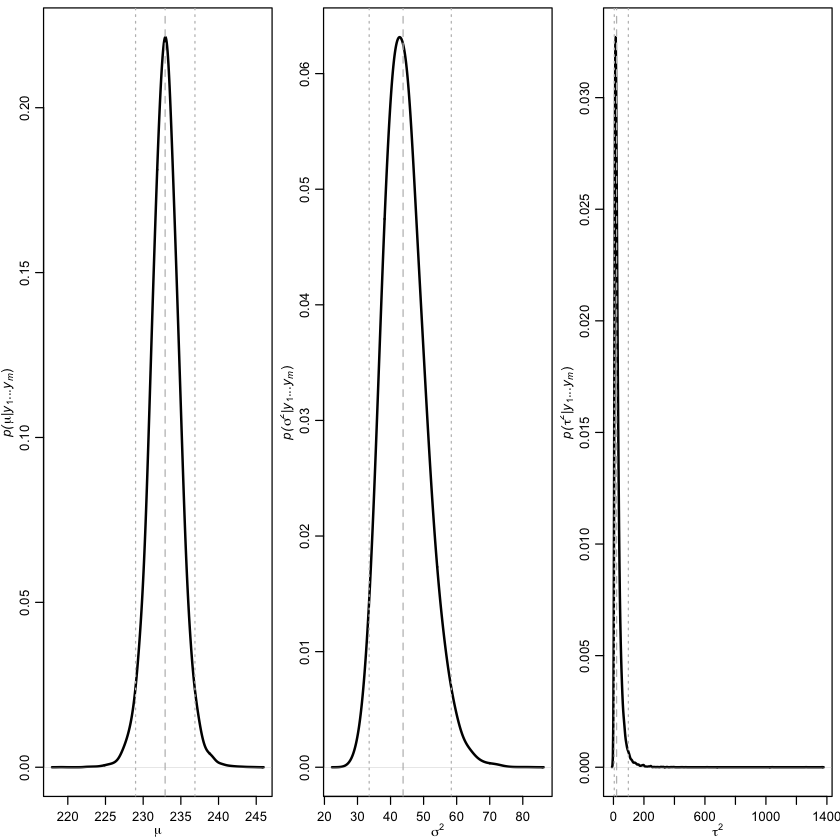

In [490]:
par(bg='white',mfrow=c(1,3),mar=c(2.75,2.75,.5,.5),mgp=c(1.7,.7,0))
plot(density(MST[,1],adj=2),xlab=expression(mu),main="",lwd=2,
     ylab=expression(paste(italic("p("),mu,"|",italic(y[1]),"...",italic(y[m]),")")))
abline( v=quantile(MST[,1],c(.025,.5,.975)),col="gray",lty=c(3,2,3) )
plot(density(MST[,2],adj=2),xlab=expression(sigma^2),main="", lwd=2,
     ylab=expression(paste(italic("p("),sigma^2,"|",italic(y[1]),"...",italic(y[m]),")")))
abline( v=quantile(MST[,2],c(.025,.5,.975)),col="gray",lty=c(3,2,3) )
plot(density(MST[,3],adj=2),xlab=expression(tau^2),main="",lwd=2,
     ylab=expression(paste(italic("p("),tau^2,"|",italic(y[1]),"...",italic(y[m]),")")))
abline( v=quantile(MST[,3],c(.025,.5,.975)),col="gray",lty=c(3,2,3) )

(d)

(e)

(f)$$

$$

2.5%        97.5% 
4.482430e-06 9.999953e-01

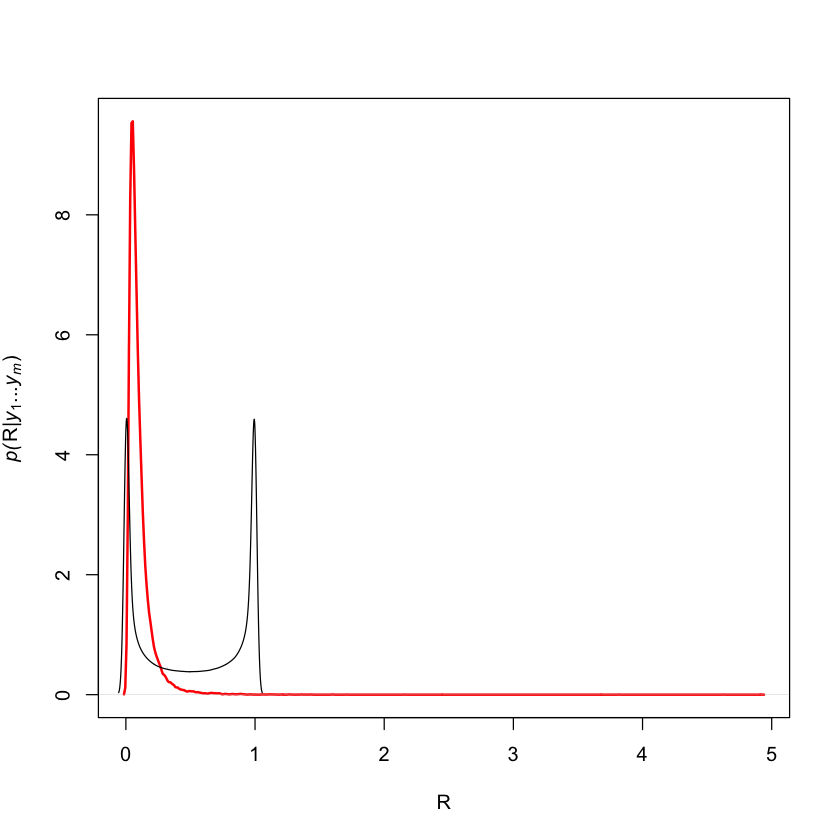

In [489]:
R<-MST[,3]/(MST[,2]+MST[3])
par(bg='white')
plot(density(R),col='red',xlab=expression(R),main="",lwd=2,ylab=expression(paste(italic("p("),R,"|",italic(y[1]),"...",italic(y[m]),")")))
l<-length(MST[,3])*100
S0<-1/rgamma(l,nu0/2,nu0*sigma0_sq/2)
T0<-1/rgamma(l,eta0/2,eta0*tao0_sq/2)
R0<-T0/(S0+T0)
lines(density(R0))
quantile(R0,c(0.025,0.975))

In [505]:
theta==max(theta)

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE